# Step N-1: Train model

In [1]:
%pylab inline
import pandas as pd
import contributions
import votes
import bills
import sqlCommands
from peoplefinder import PeopleFinder
from operator import attrgetter
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from tqdm import tqdm
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
import random

Populating the interactive namespace from numpy and matplotlib


In [2]:
#set up postgresql engine
dbname = 'legislatr'
engine = sqlCommands.get_engine(dbname)

In [3]:
#read in the feature array
query = "SELECT * FROM features WHERE final_result = 0 OR final_result = 1;"
feat = pd.read_sql_query(query,engine)

In [4]:
print(feat[feat['final_result'] == 0]['index'].size)
print(feat[feat['final_result'] == 1]['index'].size)
feat.describe()

29054
1104


,index,num_amends,result,final_result,Access Board,Administrative Conference of the U.S.,Administrative law and regulatory procedures,Afghanistan,Africa,Agricultural conservation and pollution,...,Water use and supply,Watersheds,West Bank,Wetlands,Women's health,Women's rights,World health,Wyoming,Yemen,Zimbabwe
count,30158.000000,30158.000000,30158.000000,30158.000000,30158.000000,30158.000000,30158.00000,30158.000000,30158.000000,30158.000000,...,30158.000000,30158.000000,30158.000000,30158.000000,30158.000000,30158.000000,30158.000000,30158.000000,30158.000000,30158.000000
mean,15128.723456,0.578221,1.957955,0.036607,0.000829,0.000663,0.12849,0.007195,0.006267,0.006532,...,0.022316,0.010047,0.001094,0.005339,0.014126,0.003614,0.004974,0.002421,0.001127,0.000696
std,8773.105711,11.321099,0.213815,0.187799,0.028780,0.025744,0.33464,0.084522,0.078917,0.080559,...,0.147711,0.099732,0.033062,0.072871,0.118011,0.060011,0.070351,0.049141,0.033558,0.026379
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7548.250000,0.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15106.500000,0.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22658.750000,0.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,38281.000000,621.000000,2.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Don't use these cells.

In [5]:
#terrible class imbalance. For now, oversample failure.
to_copy = feat[feat['result'] == 0]
feat = feat.append([to_copy]*10,ignore_index=True)

In [6]:
feat

,index,bill_type,bill_number,status,result,Access Board,Administrative Conference of the U.S.,Administrative law and regulatory procedures,Afghanistan,Africa,...,Water use and supply,Watersheds,West Bank,Wetlands,Women's health,Women's rights,World health,Wyoming,Yemen,Zimbabwe
0,70,s,157,ENACTED:SIGNED,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,128,s,476,ENACTED:SIGNED,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,138,s,1434,ENACTED:SIGNED,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,139,s,2583,ENACTED:SIGNED,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,155,s,1683,ENACTED:SIGNED,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,161,s,404,ENACTED:SIGNED,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,182,s,994,ENACTED:SIGNED,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,336,s,2223,PROV_KILL:CLOTUREFAILED,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,366,s,2651,ENACTED:SIGNED,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,370,s,2578,PROV_KILL:CLOTUREFAILED,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


# Continue from here down.

In [5]:
ind = np.arange(feat['index'].size)
foo = random.shuffle(ind)
print(len(ind))

30158


In [6]:
#randomize feature matrix
data = feat.iloc[np.random.permutation(len(feat))]


#data = pd.DataFrame()
#
##this could be vectorized, will do later.
#for i in tqdm(range(0,len(ind))):
#    data = data.append(feat.iloc[ind[i]])

In [7]:
print(feat[feat['index'] == 23519])
data.head(1)

       index bill_type  num_amends bill_number    status  result  \
23478  23519        hr           0          83  REFERRED       2   

       final_result  Access Board  Administrative Conference of the U.S.  \
23478             0             0                                      0   

       Administrative law and regulatory procedures    ...     \
23478                                             0    ...      

       Water use and supply  Watersheds  West Bank  Wetlands  Women's health  \
23478                     0           0          0         0               0   

       Women's rights  World health  Wyoming  Yemen  Zimbabwe  
23478               0             0        0      0         0  

[1 rows x 413 columns]


,index,bill_type,num_amends,bill_number,status,result,final_result,Access Board,Administrative Conference of the U.S.,Administrative law and regulatory procedures,...,Water use and supply,Watersheds,West Bank,Wetlands,Women's health,Women's rights,World health,Wyoming,Yemen,Zimbabwe
16930,16960,hr,0,5021,REFERRED,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
trlen = int(len(ind)*0.7)
print(trlen)
testlen = len(ind) - trlen
print(testlen)

21110
9048


In [16]:
#print(ind[0:5])
#data

[24678 16370 23039 18861 24525]


,index,bill_type,bill_number,status,result,final_result,Access Board,Administrative Conference of the U.S.,Administrative law and regulatory procedures,Afghanistan,...,Water use and supply,Watersheds,West Bank,Wetlands,Women's health,Women's rights,World health,Wyoming,Yemen,Zimbabwe
23478,23519,hr,83,REFERRED,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
517,519,s,2161,REFERRED,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
25211,25252,hr,5993,REFERRED,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15605,15634,hr,5403,REFERRED,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2976,2978,s,2805,REFERRED,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14989,15017,hr,4052,REFERRED,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26449,26490,hr,3022,REFERRED,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7653,7662,hr,1976,REFERRED,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19643,19682,s,2268,REFERRED,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9022,9031,hr,3958,REFERRED,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
data.head(3)

,index,bill_type,num_amends,bill_number,status,result,final_result,Access Board,Administrative Conference of the U.S.,Administrative law and regulatory procedures,...,Water use and supply,Watersheds,West Bank,Wetlands,Women's health,Women's rights,World health,Wyoming,Yemen,Zimbabwe
16930,16960,hr,0,5021,REFERRED,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19696,19735,s,0,2118,REPORTED,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4035,4044,hr,0,960,REFERRED,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
#create training set
tr_data = data.iloc[0:trlen]
tr_data_Y = (tr_data.as_matrix(columns=['final_result'])).flatten()
tr_data = tr_data.drop(['bill_number','bill_type','index','result','status','final_result'],axis=1)
tr_data_X = tr_data.as_matrix()
print(tr_data_X.shape)
print(tr_data_Y.shape)
#create testing set
test_data = data.iloc[trlen:-1]
test_data_Y = (test_data.as_matrix(columns=['final_result'])).flatten()
test_data = test_data.drop(['bill_number','bill_type','index','result','status','final_result'],axis=1)
test_data_X = test_data.as_matrix()
print(test_data_X.shape)
print(test_data_Y.shape)
#create "true" test with no repeat rows.
true_data = data.iloc[trlen:-1].drop_duplicates()
true_data_Y = (true_data.as_matrix(columns=['final_result'])).flatten()
true_data = true_data.drop(['bill_number','bill_type','index','result','status','final_result'],axis=1)
true_data_X = true_data.as_matrix()
print(true_data_X.shape)
print(true_data_Y.shape)

(21110, 407)
(21110,)
(9047, 407)
(9047,)
(9047, 407)
(9047,)


# Logistic Regression

In [19]:
#initialize the model
logreg = linear_model.LogisticRegression(class_weight="balanced")
#logreg = linear_model.LogisticRegression()
#train logistic regression model
logreg.fit(tr_data_X,tr_data_Y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## Predict against test

In [20]:
#predict test data
Z = logreg.predict(test_data_X)

In [21]:
acc = 0.
for i in range(0,len(Z)):
    if Z[i] == test_data_Y[i]:
        acc = acc + 1.
final = acc/len(Z)
print('Accuracy = ',final)
true_pos = 0.
false_pos = 0.
true_neg = 0.
false_neg = 0.
for i in range(0,len(Z)):
    if (Z[i] == 1) and (test_data_Y[i]) == 1:
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 1:
        false_pos = false_pos + 1.
    if (Z[i] == 1) and (test_data_Y[i]) == 0:
        false_neg = false_neg + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 0:
        true_neg = true_neg + 1.
#final = true_pos/(true_pos+false_pos)
#print('Precision = ',final)
#since negative is the weaker class
final = true_pos/(true_pos+false_pos)
print('Precision = ',final)
#final = true_pos/(true_pos+false_neg)
#print('Recall = ',final)
final = true_pos/(true_pos+false_neg)
print('Recall = ',final)

Accuracy =  0.7889908256880734
Precision =  0.5797546012269938
Recall =  0.09637939826619071


## Predict against train

In [22]:
#predict test data
Z = logreg.predict(tr_data_X)

In [24]:
acc = 0.
for i in range(0,len(Z)):
    if Z[i] == tr_data_Y[i]:
        acc = acc + 1.
final = acc/len(Z)
print('Accuracy = ',final)
true_pos = 0.
false_pos = 0.
true_neg = 0.
false_neg = 0.
for i in range(0,len(Z)):
    if (Z[i] == 1) and (tr_data_Y[i]) == 1:
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (tr_data_Y[i]) == 1:
        false_pos = false_pos + 1.
    if (Z[i] == 1) and (tr_data_Y[i]) == 0:
        false_neg = false_neg + 1.
    if (Z[i] == 0) and (tr_data_Y[i]) == 0:
        true_neg = true_neg + 1.
#final = true_pos/(true_pos+false_pos)
#print('Precision = ',final)
#since negative is the weaker class
final = true_pos/(true_pos+false_pos)
print('Precision = ',final)
#final = true_pos/(true_pos+false_neg)
#print('Recall = ',final)
final = true_pos/(true_pos+false_neg)
print('Recall = ',final)

Accuracy =  0.810279488394126
Precision =  0.7622107969151671
Recall =  0.1343757081350555


# Random Forest

In [25]:
#Random Forrest time!
#forest = RandomForestClassifier(n_estimators = 100,max_features='sqrt')
forest = RandomForestClassifier(n_estimators = 100,max_features='sqrt',class_weight='balanced')
#add more trees made little to no change.
#forest = RandomForestClassifier(n_estimators = 100,max_features='sqrt',class_weight='balanced_subsample')


In [26]:
forest = forest.fit(tr_data_X,tr_data_Y)

In [27]:
Z = forest.predict(test_data_X)

In [28]:
acc = 0.
for i in range(0,len(Z)):
    if Z[i] == test_data_Y[i]:
        acc = acc + 1.
final = acc/len(Z)
print('Accuracy = ',final)
true_pos = 0.
false_pos = 0.
true_neg = 0.
false_neg = 0.
for i in range(0,len(Z)):
    if (Z[i] == 1) and (test_data_Y[i]) == 1:
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 1:
        false_pos = false_pos + 1.
    if (Z[i] == 1) and (test_data_Y[i]) == 0:
        false_neg = false_neg + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 0:
        true_neg = true_neg + 1.
#final = true_pos/(true_pos+false_pos)
#print('Precision = ',final)
#since negative is the weaker class
final = true_pos/(true_pos+false_pos)
print('Precision = ',final)
#final = true_pos/(true_pos+false_neg)
#print('Recall = ',final)
final = true_pos/(true_pos+false_neg)
print('Recall = ',final)

Accuracy =  0.926605504587156
Precision =  0.26993865030674846
Recall =  0.17120622568093385


# against train

In [29]:
#predict test data
Z = forest.predict(tr_data_X)

In [30]:
acc = 0.
for i in range(0,len(Z)):
    if Z[i] == tr_data_Y[i]:
        acc = acc + 1.
final = acc/len(Z)
print('Accuracy = ',final)
true_pos = 0.
false_pos = 0.
true_neg = 0.
false_neg = 0.
for i in range(0,len(Z)):
    if (Z[i] == 1) and (tr_data_Y[i]) == 1:
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (tr_data_Y[i]) == 1:
        false_pos = false_pos + 1.
    if (Z[i] == 1) and (tr_data_Y[i]) == 0:
        false_neg = false_neg + 1.
    if (Z[i] == 0) and (tr_data_Y[i]) == 0:
        true_neg = true_neg + 1.
#final = true_pos/(true_pos+false_pos)
#print('Precision = ',final)
#since negative is the weaker class
final = true_pos/(true_pos+false_pos)
print('Precision = ',final)
#final = true_pos/(true_pos+false_neg)
#print('Recall = ',final)
final = true_pos/(true_pos+false_neg)
print('Recall = ',final)

Accuracy =  0.9539554713405969
Precision =  0.9357326478149101
Recall =  0.4412121212121212


# Try many different forests based on min_samples_split

In [45]:
precs = list()
accs = list()
recalls = list()

In [46]:
forest = RandomForestClassifier(n_estimators = 100,max_features='sqrt',class_weight='balanced',min_samples_split=2)
forest = forest.fit(tr_data_X,tr_data_Y)
Z = forest.predict(test_data_X)
acc = 0.
for i in range(0,len(Z)):
    if Z[i] == test_data_Y[i]:
        acc = acc + 1.
final = acc/len(Z)
print('Accuracy = ',final)
accs.append(final)
true_pos = 0.
false_pos = 0.
true_neg = 0.
false_neg = 0.
for i in range(0,len(Z)):
    if (Z[i] == 1) and (test_data_Y[i]) == 1:
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 1:
        false_pos = false_pos + 1.
    if (Z[i] == 1) and (test_data_Y[i]) == 0:
        false_neg = false_neg + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 0:
        true_neg = true_neg + 1.
#final = true_pos/(true_pos+false_pos)
#print('Precision = ',final)
#since negative is the weaker class
final = true_pos/(true_pos+false_pos)
print('Precision = ',final)
precs.append(final)
#final = true_pos/(true_pos+false_neg)
#print('Recall = ',final)
final = true_pos/(true_pos+false_neg)
print('Recall = ',final)
recalls.append(final)

Accuracy =  0.924947496407649
Precision =  0.254601226993865
Recall =  0.1599229287090559


In [47]:
forest = RandomForestClassifier(n_estimators = 100,max_features='sqrt',class_weight='balanced',min_samples_split=4)
forest = forest.fit(tr_data_X,tr_data_Y)
Z = forest.predict(test_data_X)
acc = 0.
for i in range(0,len(Z)):
    if Z[i] == test_data_Y[i]:
        acc = acc + 1.
final = acc/len(Z)
print('Accuracy = ',final)
accs.append(final)
true_pos = 0.
false_pos = 0.
true_neg = 0.
false_neg = 0.
for i in range(0,len(Z)):
    if (Z[i] == 1) and (test_data_Y[i]) == 1:
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 1:
        false_pos = false_pos + 1.
    if (Z[i] == 1) and (test_data_Y[i]) == 0:
        false_neg = false_neg + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 0:
        true_neg = true_neg + 1.
#final = true_pos/(true_pos+false_pos)
#print('Precision = ',final)
#since negative is the weaker class
final = true_pos/(true_pos+false_pos)
print('Precision = ',final)
precs.append(final)
#final = true_pos/(true_pos+false_neg)
#print('Recall = ',final)
final = true_pos/(true_pos+false_neg)
print('Recall = ',final)
recalls.append(final)

Accuracy =  0.930474190339339
Precision =  0.3159509202453988
Recall =  0.20235756385068762


In [48]:
forest = RandomForestClassifier(n_estimators = 100,max_features='sqrt',class_weight='balanced',min_samples_split=8)
forest = forest.fit(tr_data_X,tr_data_Y)
Z = forest.predict(test_data_X)
acc = 0.
for i in range(0,len(Z)):
    if Z[i] == test_data_Y[i]:
        acc = acc + 1.
final = acc/len(Z)
print('Accuracy = ',final)
accs.append(final)
true_pos = 0.
false_pos = 0.
true_neg = 0.
false_neg = 0.
for i in range(0,len(Z)):
    if (Z[i] == 1) and (test_data_Y[i]) == 1:
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 1:
        false_pos = false_pos + 1.
    if (Z[i] == 1) and (test_data_Y[i]) == 0:
        false_neg = false_neg + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 0:
        true_neg = true_neg + 1.
#final = true_pos/(true_pos+false_pos)
#print('Precision = ',final)
#since negative is the weaker class
final = true_pos/(true_pos+false_pos)
print('Precision = ',final)
precs.append(final)
#final = true_pos/(true_pos+false_neg)
#print('Recall = ',final)
final = true_pos/(true_pos+false_neg)
print('Recall = ',final)
recalls.append(final)

Accuracy =  0.9274897756162264
Precision =  0.3619631901840491
Recall =  0.20848056537102475


In [49]:
forest = RandomForestClassifier(n_estimators = 100,max_features='sqrt',class_weight='balanced',min_samples_split=16)
forest = forest.fit(tr_data_X,tr_data_Y)
Z = forest.predict(test_data_X)
acc = 0.
for i in range(0,len(Z)):
    if Z[i] == test_data_Y[i]:
        acc = acc + 1.
final = acc/len(Z)
print('Accuracy = ',final)
accs.append(final)
true_pos = 0.
false_pos = 0.
true_neg = 0.
false_neg = 0.
for i in range(0,len(Z)):
    if (Z[i] == 1) and (test_data_Y[i]) == 1:
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 1:
        false_pos = false_pos + 1.
    if (Z[i] == 1) and (test_data_Y[i]) == 0:
        false_neg = false_neg + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 0:
        true_neg = true_neg + 1.
#final = true_pos/(true_pos+false_pos)
#print('Precision = ',final)
#since negative is the weaker class
final = true_pos/(true_pos+false_pos)
print('Precision = ',final)
precs.append(final)
#final = true_pos/(true_pos+false_neg)
#print('Recall = ',final)
final = true_pos/(true_pos+false_neg)
print('Recall = ',final)
recalls.append(final)

Accuracy =  0.9302531225820714
Precision =  0.4325153374233129
Recall =  0.2402044293015332


In [50]:
forest = RandomForestClassifier(n_estimators = 100,max_features='sqrt',class_weight='balanced',min_samples_split=32)
forest = forest.fit(tr_data_X,tr_data_Y)
Z = forest.predict(test_data_X)
acc = 0.
for i in range(0,len(Z)):
    if Z[i] == test_data_Y[i]:
        acc = acc + 1.
final = acc/len(Z)
print('Accuracy = ',final)
accs.append(final)
true_pos = 0.
false_pos = 0.
true_neg = 0.
false_neg = 0.
for i in range(0,len(Z)):
    if (Z[i] == 1) and (test_data_Y[i]) == 1:
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 1:
        false_pos = false_pos + 1.
    if (Z[i] == 1) and (test_data_Y[i]) == 0:
        false_neg = false_neg + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 0:
        true_neg = true_neg + 1.
#final = true_pos/(true_pos+false_pos)
#print('Precision = ',final)
#since negative is the weaker class
final = true_pos/(true_pos+false_pos)
print('Precision = ',final)
precs.append(final)
#final = true_pos/(true_pos+false_neg)
#print('Recall = ',final)
final = true_pos/(true_pos+false_neg)
print('Recall = ',final)
recalls.append(final)

Accuracy =  0.9236210898640433
Precision =  0.4938650306748466
Recall =  0.23435225618631733


In [51]:
forest = RandomForestClassifier(n_estimators = 100,max_features='sqrt',class_weight='balanced',min_samples_split=64)
forest = forest.fit(tr_data_X,tr_data_Y)
Z = forest.predict(test_data_X)
acc = 0.
for i in range(0,len(Z)):
    if Z[i] == test_data_Y[i]:
        acc = acc + 1.
final = acc/len(Z)
print('Accuracy = ',final)
accs.append(final)
true_pos = 0.
false_pos = 0.
true_neg = 0.
false_neg = 0.
for i in range(0,len(Z)):
    if (Z[i] == 1) and (test_data_Y[i]) == 1:
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 1:
        false_pos = false_pos + 1.
    if (Z[i] == 1) and (test_data_Y[i]) == 0:
        false_neg = false_neg + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 0:
        true_neg = true_neg + 1.
#final = true_pos/(true_pos+false_pos)
#print('Precision = ',final)
#since negative is the weaker class
final = true_pos/(true_pos+false_pos)
print('Precision = ',final)
precs.append(final)
#final = true_pos/(true_pos+false_neg)
#print('Recall = ',final)
final = true_pos/(true_pos+false_neg)
print('Recall = ',final)
recalls.append(final)

Accuracy =  0.9180943959323533
Precision =  0.5460122699386503
Recall =  0.23086900129701687


In [52]:
forest = RandomForestClassifier(n_estimators = 100,max_features='sqrt',class_weight='balanced',min_samples_split=128)
forest = forest.fit(tr_data_X,tr_data_Y)
Z = forest.predict(test_data_X)
acc = 0.
for i in range(0,len(Z)):
    if Z[i] == test_data_Y[i]:
        acc = acc + 1.
final = acc/len(Z)
print('Accuracy = ',final)
accs.append(final)
true_pos = 0.
false_pos = 0.
true_neg = 0.
false_neg = 0.
for i in range(0,len(Z)):
    if (Z[i] == 1) and (test_data_Y[i]) == 1:
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 1:
        false_pos = false_pos + 1.
    if (Z[i] == 1) and (test_data_Y[i]) == 0:
        false_neg = false_neg + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 0:
        true_neg = true_neg + 1.
#final = true_pos/(true_pos+false_pos)
#print('Precision = ',final)
#since negative is the weaker class
final = true_pos/(true_pos+false_pos)
print('Precision = ',final)
precs.append(final)
#final = true_pos/(true_pos+false_neg)
#print('Recall = ',final)
final = true_pos/(true_pos+false_neg)
print('Recall = ',final)
recalls.append(final)

Accuracy =  0.9074831435835083
Precision =  0.5920245398773006
Recall =  0.21516164994425863


In [53]:
forest = RandomForestClassifier(n_estimators = 100,max_features='sqrt',class_weight='balanced',min_samples_split=256)
forest = forest.fit(tr_data_X,tr_data_Y)
Z = forest.predict(test_data_X)
acc = 0.
for i in range(0,len(Z)):
    if Z[i] == test_data_Y[i]:
        acc = acc + 1.
final = acc/len(Z)
print('Accuracy = ',final)
accs.append(final)
true_pos = 0.
false_pos = 0.
true_neg = 0.
false_neg = 0.
for i in range(0,len(Z)):
    if (Z[i] == 1) and (test_data_Y[i]) == 1:
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 1:
        false_pos = false_pos + 1.
    if (Z[i] == 1) and (test_data_Y[i]) == 0:
        false_neg = false_neg + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 0:
        true_neg = true_neg + 1.
#final = true_pos/(true_pos+false_pos)
#print('Precision = ',final)
#since negative is the weaker class
final = true_pos/(true_pos+false_pos)
print('Precision = ',final)
precs.append(final)
#final = true_pos/(true_pos+false_neg)
#print('Recall = ',final)
final = true_pos/(true_pos+false_neg)
print('Recall = ',final)
recalls.append(final)

Accuracy =  0.8726649718138609
Precision =  0.6104294478527608
Recall =  0.16258169934640523


In [54]:
forest = RandomForestClassifier(n_estimators = 100,max_features='sqrt',class_weight='balanced',min_samples_split=512)
forest = forest.fit(tr_data_X,tr_data_Y)
Z = forest.predict(test_data_X)
acc = 0.
for i in range(0,len(Z)):
    if Z[i] == test_data_Y[i]:
        acc = acc + 1.
final = acc/len(Z)
print('Accuracy = ',final)
accs.append(final)
true_pos = 0.
false_pos = 0.
true_neg = 0.
false_neg = 0.
for i in range(0,len(Z)):
    if (Z[i] == 1) and (test_data_Y[i]) == 1:
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 1:
        false_pos = false_pos + 1.
    if (Z[i] == 1) and (test_data_Y[i]) == 0:
        false_neg = false_neg + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 0:
        true_neg = true_neg + 1.
#final = true_pos/(true_pos+false_pos)
#print('Precision = ',final)
#since negative is the weaker class
final = true_pos/(true_pos+false_pos)
print('Precision = ',final)
precs.append(final)
#final = true_pos/(true_pos+false_neg)
#print('Recall = ',final)
final = true_pos/(true_pos+false_neg)
print('Recall = ',final)
recalls.append(final)

Accuracy =  0.8313253012048193
Precision =  0.6687116564417178
Recall =  0.1332518337408313


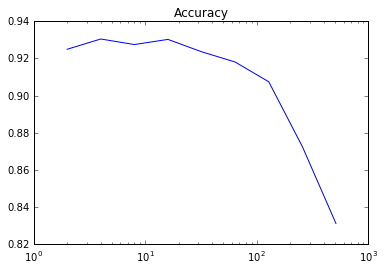

In [58]:
#plot it
x = np.asarray([2,4,8,16,32,64,128,256,512])
y_acc = np.asarray(accs)
y_prec = np.asarray(precs)
y_recs = np.asarray(recalls)
plt.plot(x,y_acc)
plt.xscale('log')
plt.title('Accuracy')

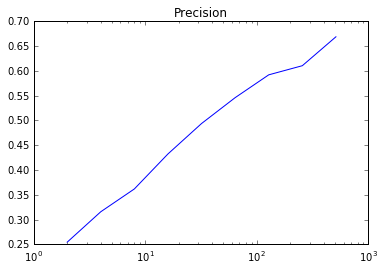

In [59]:
plt.plot(x,y_prec)
plt.xscale('log')
plt.title('Precision')

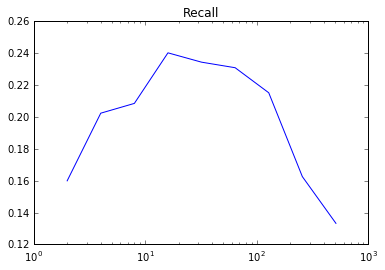

In [60]:
plt.plot(x,y_recs)
plt.xscale('log')
plt.title('Recall')

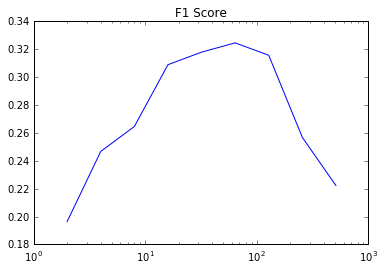

In [62]:
f = 2*((y_recs*y_prec)/(y_recs+y_prec))
plt.plot(x,f)
plt.xscale('log')
plt.title('F1 Score')

# Best model uses min_samples_split = 64 (based on F1 score).

In [63]:
#now using that model, find the worthless features.
forest = RandomForestClassifier(n_estimators = 100,max_features='sqrt',class_weight='balanced',min_samples_split=64)
forest = forest.fit(tr_data_X,tr_data_Y)
Z = forest.predict(test_data_X)
acc = 0.
for i in range(0,len(Z)):
    if Z[i] == test_data_Y[i]:
        acc = acc + 1.
final = acc/len(Z)
print('Accuracy = ',final)
accs.append(final)
true_pos = 0.
false_pos = 0.
true_neg = 0.
false_neg = 0.
for i in range(0,len(Z)):
    if (Z[i] == 1) and (test_data_Y[i]) == 1:
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 1:
        false_pos = false_pos + 1.
    if (Z[i] == 1) and (test_data_Y[i]) == 0:
        false_neg = false_neg + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 0:
        true_neg = true_neg + 1.
#final = true_pos/(true_pos+false_pos)
#print('Precision = ',final)
#since negative is the weaker class
final = true_pos/(true_pos+false_pos)
print('Precision = ',final)
precs.append(final)
#final = true_pos/(true_pos+false_neg)
#print('Recall = ',final)
final = true_pos/(true_pos+false_neg)
print('Recall = ',final)
recalls.append(final)

Accuracy =  0.9156626506024096
Precision =  0.5552147239263804
Recall =  0.2265331664580726


In [64]:
#feature importances:
f_imp = forest.feature_importances_
print(type(f_imp))
print(len(f_imp))

<class 'numpy.ndarray'>
407


In [65]:
print(f_imp)

[  1.40761774e-01   2.81757274e-05   1.75596598e-05   1.29367726e-02
   7.60951362e-04   6.43916637e-04   4.15453825e-04   8.77113772e-05
   3.88608811e-04   1.43201155e-04   7.44757575e-04   2.48756817e-04
   1.31592003e-03   1.26399772e-04   2.94737295e-03   1.09592307e-04
   5.87126684e-04   8.50551643e-04   3.45257548e-05   6.45913065e-03
   5.75336330e-04   2.04040460e-04   4.47683356e-04   4.56529926e-04
   8.87244772e-06   7.03019548e-03   7.45368865e-04   5.87185463e-05
   7.29510375e-04   5.61309791e-03   7.99939534e-04   7.43729038e-04
   1.26699302e-02   0.00000000e+00   3.09619347e-03   4.70165417e-04
   3.56626959e-05   2.97720773e-04   9.34134725e-04   6.61336814e-03
   1.64573829e-05   1.09290266e-03   1.14753682e-03   2.67136719e-03
   1.06800236e-03   1.55263595e-03   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   4.49186104e-04   2.87108103e-04
   1.70620264e-03   2.71530565e-03   2.46496705e-03   4.01256269e-04
   1.50836752e-03   9.76416646e-04

# Predict all fail

In [27]:
Z = np.zeros(len(true_data_Y)) #always predict fail
acc = 0.
for i in range(0,len(Z)):
    if Z[i] == true_data_Y[i]:
        acc = acc + 1.
final = acc/len(Z)
print('Accuracy = ',final)
true_pos = 0.
false_pos = 0.
true_neg = 0.
false_neg = 0.
for i in range(0,len(Z)):
    if (Z[i] == 1) and (test_data_Y[i]) == 1:
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 1:
        false_neg = false_neg + 1.
    if (Z[i] == 1) and (test_data_Y[i]) == 0:
        false_pos = false_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 0:
        true_neg = true_neg + 1.
#final = true_pos/(true_pos+false_pos)
#print('Precision = ',final)
#since negative is the weaker class
final = true_pos/(true_pos+false_pos)
print('Precision = ',final)
#final = true_pos/(true_pos+false_neg)
#print('Recall = ',final)
final = true_pos/(true_pos+false_neg)
print('Recall = ',final)

Accuracy =  0.965513429866254


ZeroDivisionError: float division by zero

# No longer need the boxes below

In [24]:
#repeat with predicting against true dataset
Z = logreg.predict(true_data_X)
P = logreg.predict_proba(true_data_X)
acc = 0.
for i in range(0,len(Z)):
    if Z[i] == true_data_Y[i]:
        acc = acc + 1.
final = acc/len(Z)
print('Accuracy = ',final)
true_pos = 0.
false_pos = 0.
true_neg = 0.
false_neg = 0.
for i in range(0,len(Z)):
    if (Z[i] == 1) and (test_data_Y[i]) == 1:
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 1:
        false_neg = false_neg + 1.
    if (Z[i] == 1) and (test_data_Y[i]) == 0:
        false_pos = false_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 0:
        true_neg = true_neg + 1.
#final = true_pos/(true_pos+false_pos)
#print('Precision = ',final)
#since negative is the weaker class
final = true_neg/(true_neg+false_neg)
print('Precision = ',final)
#final = true_pos/(true_pos+false_neg)
#print('Recall = ',final)
final = true_neg/(true_neg+false_pos)
print('Recall = ',final)
res = np.zeros((Z.size,2))
res[:,0]= Z
res[Z==0,1] = P[Z==0,0]*100. #convert to percent
res[Z==1,1] = P[Z==1,1]*100. #convert to percent
res_df = pd.DataFrame(res,columns=['result','confidence'])
res_df

Accuracy =  0.900497512437811
Precision =  0.5
Recall =  0.29015544041450775


,result,confidence
0,1.0,69.040271
1,1.0,99.473313
2,0.0,56.885223
3,0.0,99.234326
4,1.0,69.690624
5,1.0,98.638129
6,0.0,89.291355
7,1.0,99.999987
8,1.0,93.440159
9,0.0,87.105848


In [25]:
#repeat with predicting against true dataset
Z = forest.predict(true_data_X)
P = forest.predict_proba(true_data_X)
acc = 0.
for i in range(0,len(Z)):
    if Z[i] == true_data_Y[i]:
        acc = acc + 1.
final = acc/len(Z)
print('Accuracy = ',final)
true_pos = 0.
false_pos = 0.
true_neg = 0.
false_neg = 0.
for i in range(0,len(Z)):
    if (Z[i] == 1) and (test_data_Y[i]) == 1:
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 1:
        false_neg = false_neg + 1.
    if (Z[i] == 1) and (test_data_Y[i]) == 0:
        false_pos = false_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 0:
        true_neg = true_neg + 1.
#final = true_pos/(true_pos+false_pos)
#print('Precision = ',final)
#since negative is the weaker class
final = true_neg/(true_neg+false_neg)
print('Precision = ',final)
#final = true_pos/(true_pos+false_neg)
#print('Recall = ',final)
final = true_neg/(true_neg+false_pos)
print('Recall = ',final)
res = np.zeros((Z.size,2))
res[:,0]= Z
res[Z==0,1] = P[Z==0,0]*100. #convert to percent
res[Z==1,1] = P[Z==1,1]*100. #convert to percent
res_df = pd.DataFrame(res,columns=['result','confidence'])
res_df

Accuracy =  0.9228855721393034
Precision =  0.5309734513274337
Recall =  0.31088082901554404


,result,confidence
0,0.0,69.988806
1,1.0,100.000000
2,0.0,100.000000
3,0.0,100.000000
4,1.0,88.000000
5,1.0,100.000000
6,0.0,100.000000
7,1.0,88.000000
8,1.0,92.500000
9,0.0,100.000000


In [26]:
Z = np.zeros(len(true_data_Y))+1 #always predict pass
acc = 0.
for i in range(0,len(Z)):
    if Z[i] == true_data_Y[i]:
        acc = acc + 1.
final = acc/len(Z)
print('Accuracy = ',final)
true_pos = 0.
false_pos = 0.
true_neg = 0.
false_neg = 0.
for i in range(0,len(Z)):
    if (Z[i] == 1) and (test_data_Y[i]) == 1:
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 1:
        false_neg = false_neg + 1.
    if (Z[i] == 1) and (test_data_Y[i]) == 0:
        false_pos = false_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i]) == 0:
        true_neg = true_neg + 1.
#final = true_pos/(true_pos+false_pos)
#print('Precision = ',final)
#since negative is the weaker class
final = true_neg/(true_neg+false_neg)
print('Precision = ',final)
#final = true_pos/(true_pos+false_neg)
#print('Recall = ',final)
final = true_neg/(true_neg+false_pos)
print('Recall = ',final)

Accuracy =  0.7960199004975125


ZeroDivisionError: float division by zero

In [ ]:
#save models
import pickle
#save trained logistic regression model
logreg_file = open('logreg_model_subjects.pkl', 'wb')
s = pickle.dump(logreg,logreg_file)
logreg_file.close()
#save trained random forest model
forest_file = open('random_forest_model_subjects.pkl', 'wb')
s = pickle.dump(forest,forest_file)
forest_file.close()

In [55]:
forest_file = open('random_forest_model_subjects.pkl', 'rb')
test = pickle.load(forest_file)
forest_file.close()